In [9]:
import glob
import re

import numpy as np
import pandas as pd
import tqdm
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
# pd.options.display.max_columns = 2000

/tmp/ipykernel_268814/2048820180.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [10]:
def convert_times_2_timedelta(time_s):
    time_s = time_s.strip()
    if not time_s.endswith("s"):
        return float(time_s)
    else:
        return pd.Timedelta(time_s) / np.timedelta64(1, "us")

def remove_emptystr_in_list(l):
    return list(filter(lambda x: x.strip() != "", l))


def strip_each_in_list(l):
    return [each.strip() for each in l]


class IteratorLogs():

    def __init__(self, logfile) -> None:
        with open(logfile) as f:
            self.lines = f.readlines()
        self.index = 0

    def next(self):
        temp = self.next_line()
        # filter GLOG
        while temp.find('.h:') != -1 or temp.find('.cc:') != -1:
            temp = self.next_line()
        # print(self.index, temp)
        return temp

    def next_line(self):
        if self.index == len(self.lines):
            raise StopIteration()
        temp = self.lines[self.index]
        self.index += 1
        return temp


# run_log_file to [{ts: ts1, k1: v, k2: v}, (ts2, {})]
def parse_log(logfile, ):
    iter_log = IteratorLogs(logfile)

    dic = defaultdict(lambda: [])

    proc_num = -1
    perf_counter_names = set()
    
    import re
    
    while True:
        try:
            each_line = iter_log.next()
            each_line = each_line.strip()
            r = re.search(r'\[proc (\d)\] (\d+) steps, (total:.*$)', each_line)
            if r:
                proc = int(r[1])
                proc_num = max(proc_num,  proc)
                step = int(r[2])
                items = r[3].split(", ")
                items = [(each.split(": ")[0], each.split(": ")[1]) for each in items]
                for each_k, each_v in items:
                    dic[f'proc{proc}_{each_k}'] = [float(each_v)]
                    perf_counter_names.add(each_k)
                continue

            r = re.search(r'Step(\d+):rank(\d), (time: .*$)', each_line)
            if r:
                proc = int(r[2])
                proc_num = max(proc_num,  proc)
                step = int(r[1])
                items = r[3].split(", ")
                items = [(each.split(": ")[0], each.split(": ")[1]) for each in items]
                for each_k, each_v in items:
                    dic[f'proc{proc}_{each_k}'] = [float(each_v)]
                    perf_counter_names.add(each_k)
                continue
                
            if each_line.startswith('+----'):
                each_line = iter_log.next()
                assert each_line.startswith('| Name')

                each_line = iter_log.next()
                assert each_line.startswith('+----')

                each_line = iter_log.next()  # Index Part
                while not each_line.startswith('+-----'):
                    r = each_line.split("|")
                    r = remove_emptystr_in_list(r)
                    r = strip_each_in_list(r)
                    if (len(r) == 3 or len(r) == 4) and r[0] != "Name":
                        for j in range(1, len(r)):
                            r[j] = convert_times_2_timedelta(r[j])
                        dic[f"[D] {r[0]}_Mean"].append(r[1])
                        dic[f"[D] {r[0]}_P99"].append(r[2])
                        if len(r) == 4:
                            dic[f"{r[0]}_now"].append(r[3])
                    each_line = iter_log.next()
                assert each_line.startswith('+-')
            
            
        except StopIteration:
            # if 'ts' in dic.keys():
            #     results.append(dic)
            break
    
    ret_dict = dict()
    # 对每个proc 取倒数三个
    
    
    per_rank_statistic_keys = [each for each in dic.keys() if each.startswith('proc')]

    import re
    per_rank_statistic_keys = [re.sub(r'proc\d+_', '', each) for each in per_rank_statistic_keys]
    
    normal_statistic_keys = [each for each in dic.keys() if not each.startswith('proc')]
    
    for name in per_rank_statistic_keys :
        items = [dic[f'proc{proc}_{name}'] for proc in range(proc_num)]
        ret_dict[f'{name}_mean'] = np.mean(items)
        ret_dict[f'{name}_jicha'] = np.max(items) - np.min(items)

    for each_k in normal_statistic_keys:
        each_v = dic[each_k]
        # ret_dict[f"{each_k}_jicha"] = max(each_v[-3:]) - min(each_v[-3:])
        # ret_dict[each_k] = np.mean(each_v[-3:])
        ret_dict[each_k] = each_v[-1]

    
    return ret_dict

    # # 对所有的proc的每一项，取均值，与极差
    # ret_dict = dict()
    # proc_num = proc_num+1

    # print(ret_dict)
    # for name in perf_counter_names:
    #     items = [dic[f'proc{proc}_{name}'] for proc in range(proc_num)]
    #     ret_dict[f'{name}_mean'] = np.mean(items)
    #     ret_dict[f'{name}_jicha'] = np.max(items) - np.min(items)


In [11]:
def parse_logs_to_df(exp_dir):
    df = pd.DataFrame()
    if exp_dir.find("run_") == -1:
        log_files = glob.glob(f"{exp_dir}/*")
    else:
        log_files = glob.glob(f"{exp_dir}")
        
    run_dfs = []
        
    for run_path in tqdm.tqdm(log_files):
        run_id = run_path.split("/")[-1]
        logfile = glob.glob(f'{run_path}/log')
        assert len(logfile) == 1
        logfile = logfile[0]
        config_file = f'{run_path}/config'

        run_df = parse_log(logfile,)
        run_df["run_id"] = run_id
        import json
        with open(config_file, "r") as f:
            config_dict = json.load(f)

        for each_k, each_v in config_dict.items():
            run_df[each_k] = each_v

        for each_k in list(run_df.keys()):
            run_df[each_k] = [run_df[each_k]]

        run_df = pd.DataFrame.from_dict(run_df)
        run_dfs.append(run_df)
        
    df = pd.concat(run_dfs, axis=0,  ignore_index=True)
    # df = df.append(run_df, ignore_index=True)
    for each in ['max_step', 'no_save_emb', 'command']:
        if each in df.keys():
            del df[each]
    # df = df.astype({k: int for k in int_columns})
    return df


In [12]:
def TidyQueryStr(query_string):
    # query_string = query_string.replace('false', '"false"')
    # query_string = query_string.replace('true', '"true"')
    return query_string


def QueryStr(kv_pair):
    kEQvList = []
    for k, v in kv_pair:
        if type(v) is str:
            kEQvList.append(f'`{k}` == "{v}"')
        else:
            kEQvList.append(f'`{k}` == {v}')
        # kEQvList.append(f'`{k}` == {v}')
    return ' and '.join(kEQvList)


def DecoupleAnalysis(df, for_variables, line_variables, x_variable,
                     y_variable, sort_variable,
                     mark_variable=None, legend_loc = 'in'):
    if type(for_variables) is not list:
        for_variables = [for_variables]
    if type(line_variables) is not list:
        line_variables = [line_variables]

    if type(y_variable) is not list:
        y_variable = [y_variable]

    if type(x_variable) is not str:
        raise Exception("current only support one x variable")

    # for each graph
    for each_graph_specified in itertools.product(*[df[_].unique() for _ in for_variables]):
        kv_pair = list(zip(for_variables, each_graph_specified))
        graph_query_string = QueryStr(kv_pair)
        # graph_query_string = ' and '.join([f'{k}=={v}' for k,v in kv_pair])
        # graph_query_string = ' and '.join([f'{k}=={"\"" + v +"\"" if type(v) is str else v}' for k,v in kv_pair])
        graph_query_string = TidyQueryStr(graph_query_string)
        # display("graph_query_string", graph_query_string)

        sub_df = df.query(graph_query_string)

        
        if sub_df.shape[0] == 0:
            continue

        plt.figure(figsize=(10, 5))
        plt.title(f'{kv_pair}')
        # for each line
        for each_line_specified in itertools.product(*[sub_df[_].unique() for _ in line_variables]):
            line_specified_kv_pair = list(
                zip(line_variables, each_line_specified))
            # convert string to "string" for query

            # for each in range(len(line_specified_kv_pair)):
            # 	if type(line_specified_kv_pair[each][1]) == str:
            # 		line_specified_kv_pair[each] =  (line_specified_kv_pair[each][0], f'"{line_specified_kv_pair[each][1]}"')

            # line_query_string = ' and '.join([f'{k}=={v}' for k,v in line_specified_kv_pair])
            line_query_string = QueryStr(line_specified_kv_pair)
            line_query_string = TidyQueryStr(line_query_string)
            # display(line_query_string)
            subsub_df = sub_df.query(line_query_string)

            # 避免画两组数据在一根线上
            if len(subsub_df[sort_variable].unique()) != len(subsub_df):
                display(subsub_df)
                subsub_df.to_csv("fordebug.csv")
                raise Exception(f"len(subsub_df[sort_variable].unique()) != len(subsub_df)"
                                f"({len(subsub_df[sort_variable].unique())} vs {len(subsub_df)})"
                                )

            for each_y_variable in y_variable:
                if mark_variable is None:
                    other_variables = (subsub_df['run_id'],)
                else:
                    # other_variables = (subsub_df['run_id'], subsub_df[mark_variable])
                    other_variables = (subsub_df[mark_variable], )
                xy_pairs = sorted(zip(subsub_df[x_variable], subsub_df[each_y_variable],
                                  *other_variables, subsub_df[sort_variable]), key=lambda x: x[-1])
                x = [each[0] for each in xy_pairs]
                y = [each[1] for each in xy_pairs]
                z = [each[2:-1] for each in xy_pairs]

                if len(x) != 0:
                    plt.plot(
                        x, y, label=f"{line_specified_kv_pair}_{each_y_variable}")

                if mark_variable is not None:
                    for each_x, each_y, each_z in zip(x, y, z):
                        plt.annotate(f'{each_z}', (each_x, each_y), )

        plt.xlabel(x_variable)
        plt.ylabel(str(y_variable))
        if legend_loc == 'in':
            plt.legend(bbox_to_anchor=(0., 1.2), loc='lower left',)
        else:
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()

        # break


In [13]:
df_a30 = parse_logs_to_df("../benchmark/log/0115-exp0-bigmodel-A30")
df_a30['gpu_type'] = "a30"


  0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 56/56 [00:00<00:00, 426.41it/s]


## exp0 DGL_KE: 3090 v.s. A30

100%|██████████| 20/20 [00:00<00:00, 526.39it/s]


Index(['total_mean', 'total_jicha', 'sample_mean', 'sample_jicha',
       'forward_mean', 'forward_jicha', 'backward_mean', 'backward_jicha',
       'update_mean', 'update_jicha', '[D] AfterBackward_Mean',
       '[D] AfterBackward_P99', '[D] BlockToStepN_Mean',
       '[D] BlockToStepN_P99', '[D] ProcessBack:Shuffle_Mean',
       '[D] ProcessBack:Shuffle_P99', '[D] ProcessBack:UpdateCache_Mean',
       '[D] ProcessBack:UpdateCache_P99', '[D] ProcessBack:UpdateFull_Mean',
       '[D] ProcessBack:UpdateFull_P99', '[D] ProcessOneStep_Mean',
       '[D] ProcessOneStep_P99', 'run_id', 'model_name', 'nr_gpus',
       'batch_size', 'cache_ratio', 'log_interval', 'neg_sample_size',
       'regularization_coef', 'gamma', 'lr', 'batch_size_eval', 'test',
       'mix_cpu_gpu', 'dataset', 'hidden_dim', 'use_my_emb', 'cached_emb_type',
       'backwardMode', 'gpu_type'],
      dtype='object')

,throughput,batch_size,backwardMode,cached_emb_type,use_my_emb
0,89505.482211,1000,CppSync,KnownLocalCachedEmbedding,true
1,115556.839520,1000,CppSync,None,false
2,65183.736658,2000,PySync,KnownLocalCachedEmbedding,true
3,204950.843821,8000,CppSync,None,false
4,34396.273737,600,PySync,KnownLocalCachedEmbedding,true
5,143850.395589,2000,CppSync,None,false
6,172061.511991,4000,CppSync,None,false
7,106194.690265,1000,PySync,KGExternelEmbedding,true
8,112617.896861,2000,CppSync,KnownLocalCachedEmbedding,true
9,194793.336445,8000,PySync,KGExternelEmbedding,true


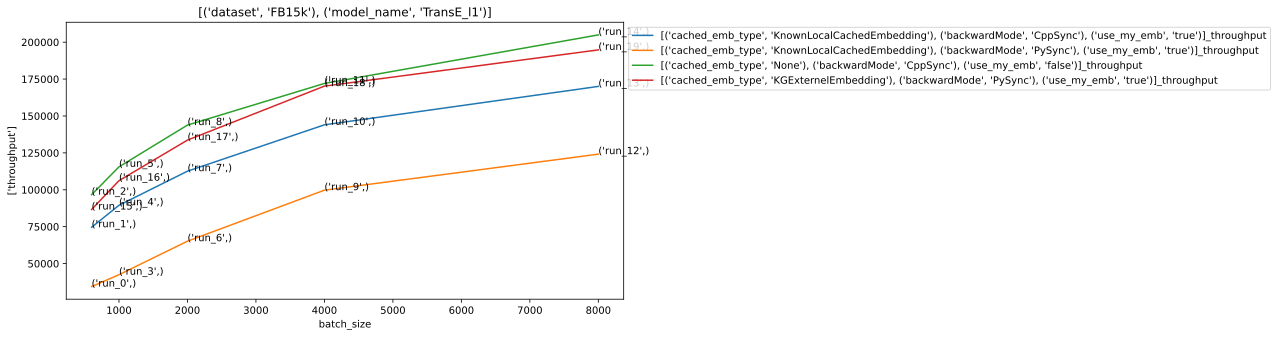

In [14]:
# df_3090 = parse_logs_to_df("../benchmark/log/exp0-bigmodel-3090")
# df_3090['gpu_type'] = "3090"

df_a30 = parse_logs_to_df("../benchmark/log/exp0-bigmodel-A30")
df_a30['gpu_type'] = "a30"

# df = pd.concat([df_3090, df_a30], axis=0, ignore_index=True)
df = pd.concat([df_a30], axis=0, ignore_index=True)
display(df.columns)

df['num_workers'] =  df['nr_gpus'].apply(lambda x: max(1, x))

df['throughput'] = df['num_workers'] * df['batch_size'] * df['log_interval'] / df['total_mean']

query_df = df
query_df = df[df['dataset'] == "FB15k"]


display(query_df[['throughput', "batch_size", "backwardMode", "cached_emb_type", "use_my_emb"]])

DecoupleAnalysis(df, 
for_variables = ['dataset', 'model_name'], 
line_variables = ['cached_emb_type', 'backwardMode', 'use_my_emb'], 
x_variable = 'batch_size', 
y_variable = ['throughput',],
sort_variable = 'batch_size',
mark_variable= 'run_id',
legend_loc='out'
)

## exp1 macro perf emb: 3090

100%|██████████| 36/36 [00:00<00:00, 381.80it/s]


,time_mean,time_jicha,per_step_mean,per_step_jicha,[D] Forward_Mean,[D] Forward_P99,[D] Backward_Mean,[D] Backward_P99,[D] Optimize_Mean,[D] Optimize_P99,...,distribution,zipf_alpha,[D] ProcessBack:Shuffle_Mean,[D] ProcessBack:Shuffle_P99,[D] ProcessBack:UpdateCache_Mean,[D] ProcessBack:UpdateCache_P99,[D] ProcessBack:UpdateFull_Mean,[D] ProcessBack:UpdateFull_P99,[D] ProcessOneStep_Mean,[D] ProcessOneStep_P99
0,4.122000,0.000,0.040810,2.000000e-06,1145.000,534.357,39162.000,27618.000,10715.000,11202.000,...,zipf,0.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.122000,0.000,0.040810,1.000000e-06,423.105,463.307,40802.000,26470.000,10475.000,11343.000,...,zipf,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.423000,0.000,0.043795,0.000000e+00,20617.000,37368.000,26057.000,34312.000,92.426,225.852,...,zipf,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.438333,0.001,0.043946,1.000000e-05,19630.000,36401.000,25781.000,39389.000,105.895,488.563,...,zipf,0.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.464000,0.000,0.044199,3.000000e-06,17202.000,33156.000,29297.000,37282.000,93.823,189.157,...,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.656000,0.000,0.016395,0.000000e+00,372.485,446.287,493.682,814.621,82.171,193.183,...,zipf,0.90,4778.0,4463.0,12292.0,6052.0,6257.000,9909.0,23641.0,20637.0
6,1.583000,0.000,0.015676,0.000000e+00,358.299,491.598,414.548,645.669,95.800,275.550,...,zipf,0.99,3539.0,5122.0,12785.0,7685.0,4222.000,7378.0,20822.0,21679.0
7,6.847000,0.000,0.067790,0.000000e+00,440.245,565.070,75341.000,75178.000,14257.000,18483.000,...,zipf,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.502000,0.000,0.024771,1.000000e-06,396.202,527.540,774.585,982.431,98.281,236.211,...,uniform,NaN,2805.0,2866.0,10548.0,3834.0,1410.000,1775.0,15070.0,8398.0
9,6.736667,0.001,0.066698,0.000000e+00,513.909,464.724,74833.000,62727.000,14439.000,20766.000,...,zipf,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


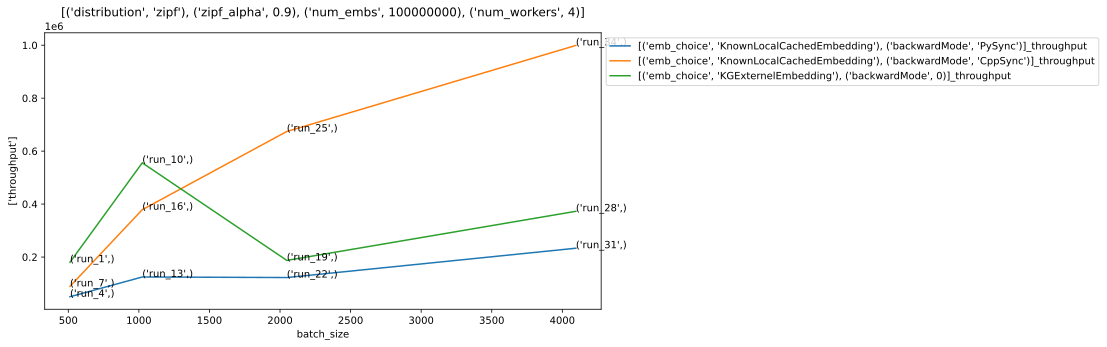

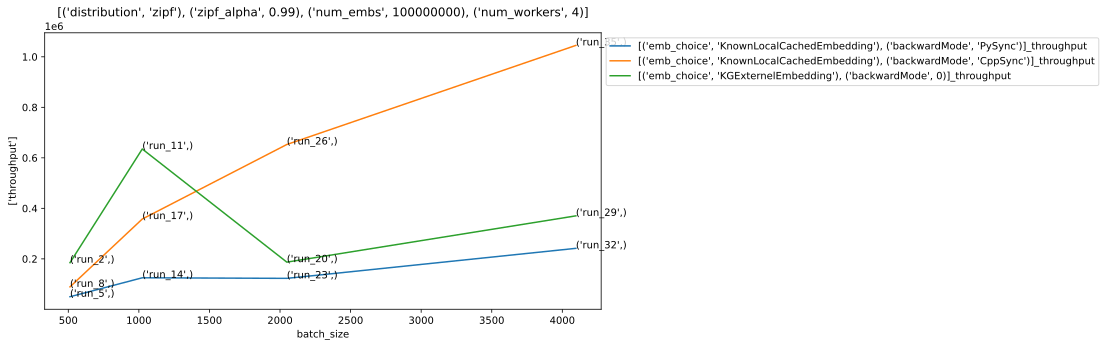

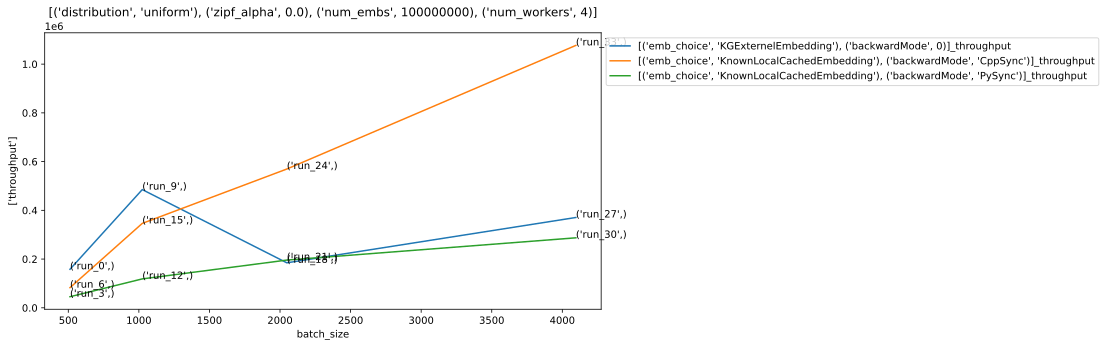

In [15]:
df = parse_logs_to_df("../benchmark/log/exp1-macro-perf-emb-A30")
display(df)

# # NOTE(1): 1000 是统计周期的step个数！！！！！！！
df['throughput'] = df['num_workers'] * df['batch_size'] * (1 / df['per_step_mean'])
df = df.fillna(0)

# show_df = df[df['num_embs'] == int(100*1e6)]
show_df = df
DecoupleAnalysis(show_df, 
for_variables = ['distribution', 'zipf_alpha', 'num_embs', 'num_workers'], 
line_variables = ['emb_choice', 'backwardMode'], 
x_variable = 'batch_size', 
y_variable = ['throughput',],
sort_variable = 'batch_size',
mark_variable="run_id",
legend_loc='out'
)

100%|██████████| 24/24 [00:00<00:00, 259.10it/s]


,time_mean,time_jicha,per_step_mean,per_step_jicha,[D] Forward_Mean,[D] Forward_P99,[D] Backward_Mean,[D] Backward_P99,[D] Optimize_Mean,[D] Optimize_P99,...,num_workers,num_embs,batch_size,run_steps,log_interval,emb_choice,backwardMode,backgrad_init,distribution,zipf_alpha
0,4.916333,0.001,0.048678,2.000000e-06,316.383,574.958,1148.000,1312.000,91.193,245.286,...,4,100000000,512,300,100,KnownLocalCachedEmbedding,CppAsyncV2,both,uniform,NaN
1,5.853000,0.000,0.057951,1.000000e-06,251.836,430.954,1132.000,1260.000,71.584,162.928,...,4,100000000,512,300,100,KnownLocalCachedEmbedding,CppAsyncV2,both,zipf,0.9
2,24.580000,0.000,0.243368,1.000000e-06,316.272,396.636,941.697,1102.000,98.980,231.623,...,4,100000000,4096,300,100,KnownLocalCachedEmbedding,CppAsyncV2,cpu,uniform,NaN
3,2.248000,0.000,0.022257,0.000000e+00,631.387,849.740,17448.000,23010.000,226.425,561.486,...,4,100000000,1024,300,100,KGExternelEmbedding,NaN,NaN,uniform,NaN
4,42.006000,0.000,0.415898,3.000000e-06,290.269,385.026,1329.000,1538.000,89.616,205.876,...,4,100000000,4096,300,100,KnownLocalCachedEmbedding,CppAsyncV2,both,zipf,0.9
5,14.089000,0.000,0.139495,0.000000e+00,316.838,423.023,897.413,1052.000,98.256,245.797,...,4,100000000,2048,300,100,KnownLocalCachedEmbedding,CppAsyncV2,cpu,uniform,NaN
6,4.496000,0.000,0.044515,3.000000e-06,596.099,787.334,21720.000,24833.000,227.607,646.731,...,4,100000000,512,300,100,KGExternelEmbedding,NaN,NaN,uniform,NaN
7,9.031000,0.000,0.089415,0.000000e+00,385.965,483.510,913.914,1026.000,114.024,223.262,...,4,100000000,1024,300,100,KnownLocalCachedEmbedding,CppAsyncV2,cpu,uniform,NaN
8,32.696000,0.000,0.323719,0.000000e+00,280.575,442.397,1292.000,1508.000,90.954,169.739,...,4,100000000,4096,300,100,KnownLocalCachedEmbedding,CppAsyncV2,both,uniform,NaN
9,10.467000,0.000,0.103634,3.000000e-06,288.397,476.187,1191.000,1605.000,89.072,237.107,...,4,100000000,1024,300,100,KnownLocalCachedEmbedding,CppAsyncV2,both,zipf,0.9


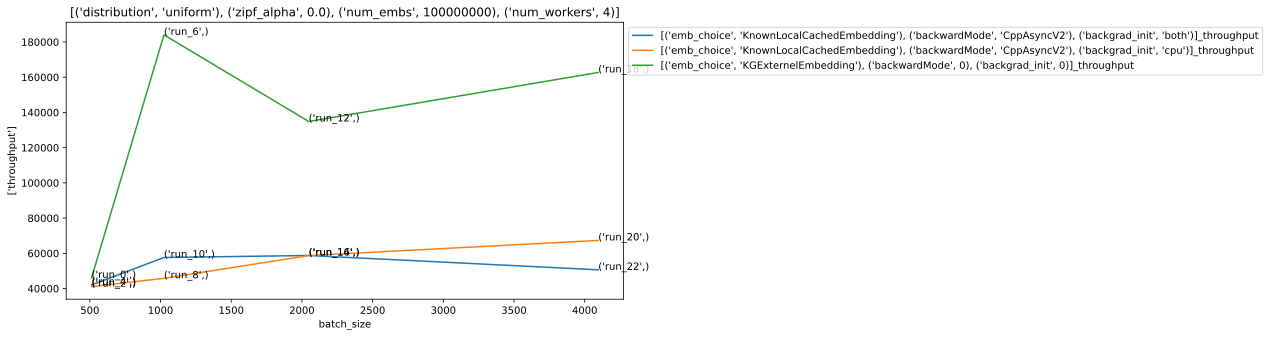

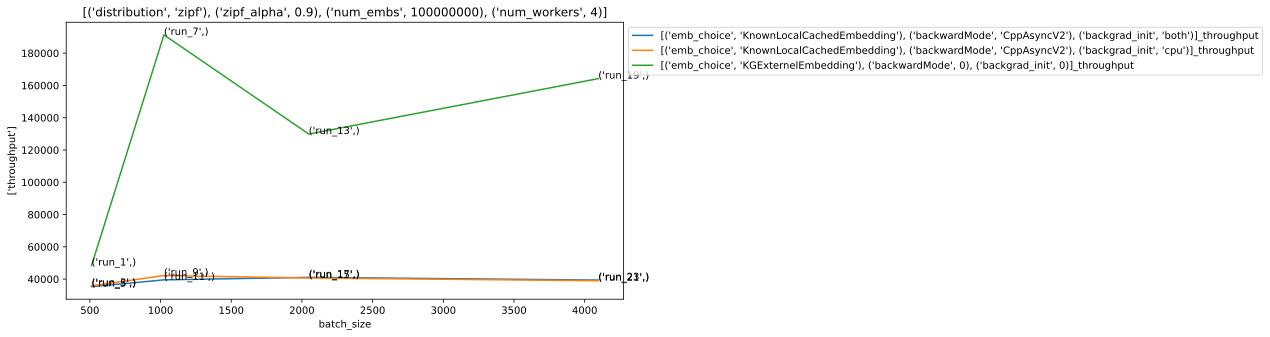

In [16]:
df = parse_logs_to_df("../benchmark/log/0115-exp1-macro-perf-emb-A30")
display(df)

# # NOTE(1): 1000 是统计周期的step个数！！！！！！！
df['throughput'] = df['num_workers'] * df['batch_size'] * (1 / df['per_step_mean'])
df = df.fillna(0)

# show_df = df[df['num_embs'] == int(100*1e6)]
show_df = df
DecoupleAnalysis(show_df, 
for_variables = ['distribution', 'zipf_alpha', 'num_embs', 'num_workers'], 
line_variables = ['emb_choice', 'backwardMode', 'backgrad_init'], 
x_variable = 'batch_size', 
y_variable = ['throughput',],
sort_variable = 'batch_size',
mark_variable="run_id",
legend_loc='out'
)

# Moti

100%|██████████| 96/96 [00:00<00:00, 289.77it/s]


Index(['time_mean', 'time_jicha', 'per_step_mean', 'per_step_jicha',
       '[D] bucket keys_Mean', '[D] bucket keys_P99',
       '[D] forward: a2a keys_Mean', '[D] forward: a2a keys_P99',
       '[D] forward: search cache_Mean', '[D] forward: search cache_P99',
       '[D] forward: a2a values_Mean', '[D] forward: a2a values_P99',
       '[D] forward: join_Mean', '[D] forward: join_P99', '[D] Forward_Mean',
       '[D] Forward_P99', '[D] back: aggr dram keys_Mean',
       '[D] back: aggr dram keys_P99', '[D] back: set dram grad_Mean',
       '[D] back: set dram grad_P99', '[D] back: a2a grad_Mean',
       '[D] back: a2a grad_P99', '[D] back: grad sum & grad cache_Mean',
       '[D] back: grad sum & grad cache_P99', '[D] Backward_Mean',
       '[D] Backward_P99', '[D] Optimize_Mean', '[D] Optimize_P99',
       '[D] E2E-100_Mean', '[D] E2E-100_P99', 'run_id', 'num_workers',
       'num_embs', 'batch_size', 'run_steps', 'log_interval', 'cache_ratio',
       'emb_choice', 'distribution', '

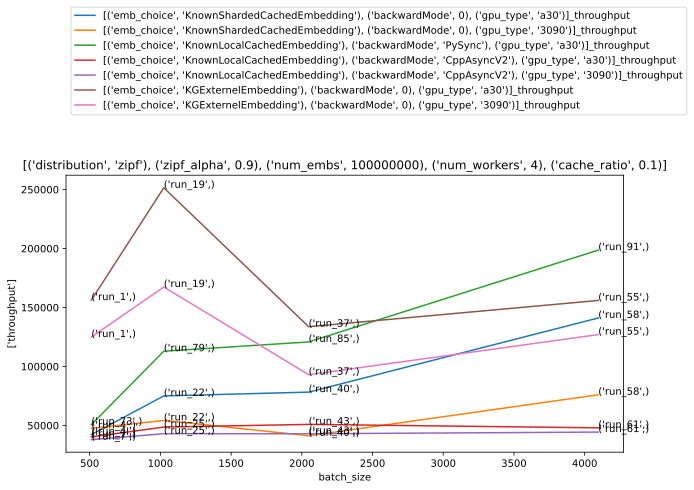

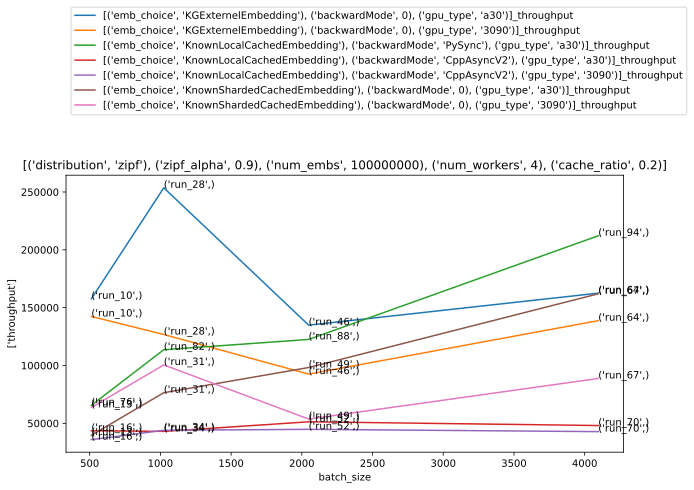

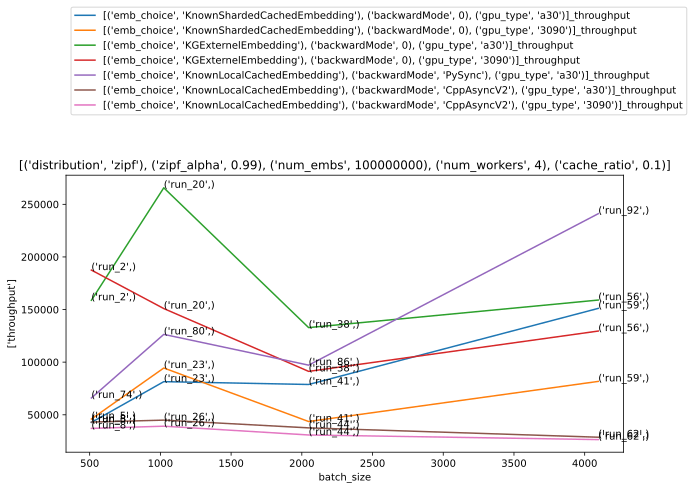

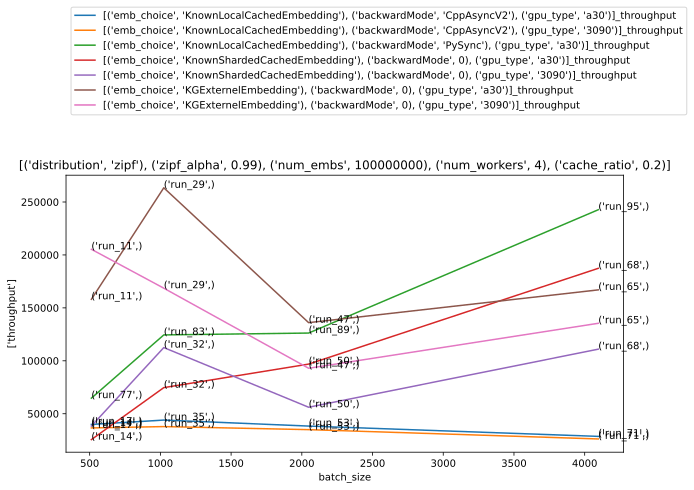

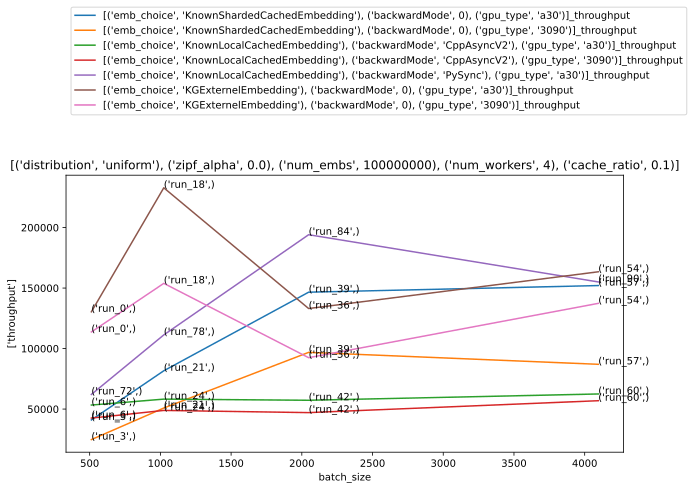

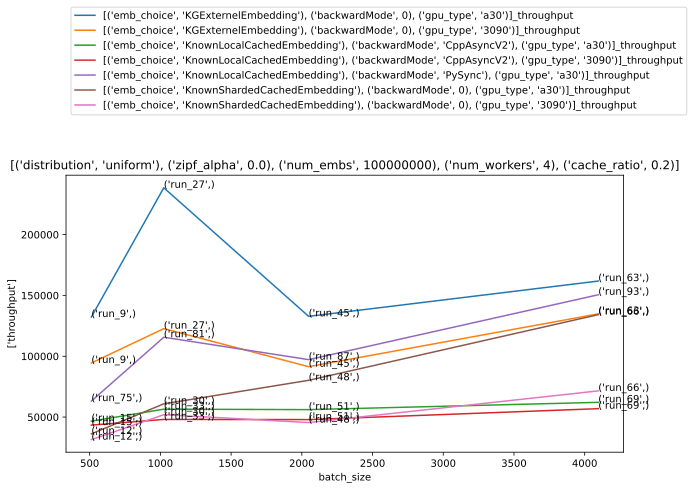

In [17]:
df_3090 = parse_logs_to_df("../benchmark/log/0116-exp2-motiv-emb-3090")
df_3090['gpu_type'] = "3090"

df_a30 = parse_logs_to_df("../benchmark/log/0116-exp2-motiv-emb-A30")
df_a30['gpu_type'] = "a30"

df = pd.concat([df_a30, df_3090], axis=0, ignore_index=True)
display(df.columns)

df['throughput'] = df['num_workers'] * df['batch_size'] * (1 / df['per_step_mean'])
df = df.fillna(0)

# show_df = df[df['emb_choice'] == 'KnownShardedCachedEmbedding']
show_df = df

DecoupleAnalysis(show_df, 
for_variables = ['distribution', 'zipf_alpha', 'num_embs', 'num_workers', "cache_ratio"], 
line_variables = ['emb_choice', 'backwardMode', 'gpu_type'], 
x_variable = 'batch_size', 
y_variable = ['throughput',],
sort_variable = 'batch_size',
mark_variable="run_id",
legend_loc='in'
)

In [24]:


show_df = df.query("run_id == 'run_69' or run_id == 'run_66'")
# show_df= df[df['run_id'] == 'run_69' or df['run_id'] == 'run_66']
display(show_df.T)

,6,63,102,143
time_mean,26.642,12.329,29.075,23.130333
time_jicha,0.0,0.0,0.0,0.005
per_step_mean,0.263782,0.122068,0.287872,0.229015
per_step_jicha,0.0,0.0,0.0,0.000055
[D] bucket keys_Mean,0.0,1653.0,0.0,1808.0
[D] bucket keys_P99,0.0,2594.0,0.0,2617.0
[D] forward: a2a keys_Mean,0.0,1043.0,0.0,1138.0
[D] forward: a2a keys_P99,0.0,2272.0,0.0,7214.0
[D] forward: search cache_Mean,0.0,162.146,0.0,217.7
[D] forward: search cache_P99,0.0,226.438,0.0,293.514
